## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import hashlib

##  Enhancing Clustering Accuracy with Data Transformation

Clustering on original images:
Cluster 0 purity: 0.2797
Cluster 1 purity: 0.3539
Cluster 2 purity: 0.3722
Cluster 3 purity: 0.8081
Average purity across clusters: 0.4535

Clustering on transformed (rotated) images:
Cluster 0 purity: 0.3953
Cluster 1 purity: 0.5425
Cluster 2 purity: 0.5419
Cluster 3 purity: 0.9189
Average purity across clusters: 0.5996


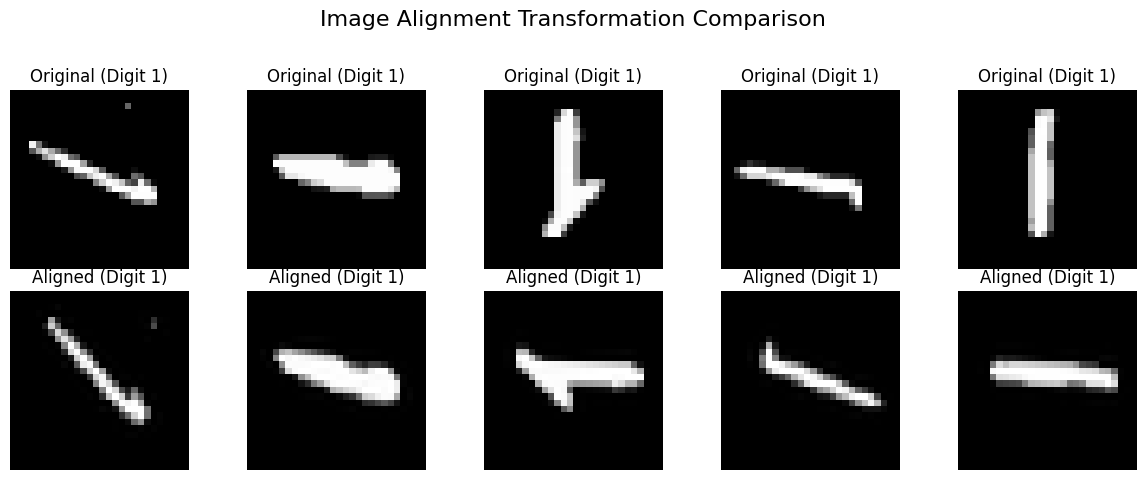

In [7]:
# Configuration
username = "sudershan.sarraf"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
np.random.seed(seed)

# Q7.1 Load Data
X_modified = np.load('Data/Q7/X_modified.npy')
y_true = np.load('Data/Q7/y_true.npy')
data_matrix = X_modified.reshape(X_modified.shape[0], -1)

# Custom PCA and GMM classes (as required by the assignment)
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean_vector = None
        self.pca_vectors = None

    def fit(self, X):
        self.mean_vector = np.mean(X, axis=0)
        centered_data = X - self.mean_vector
        cov_matrix = np.cov(centered_data, rowvar=False)
        eigvals, eigvecs = np.linalg.eigh(cov_matrix)
        sorted_indices = np.argsort(eigvals)[::-1]
        self.pca_vectors = eigvecs[:, sorted_indices][:, :self.n_components]

    def transform(self, X):
        centered = X - self.mean_vector
        return centered @ self.pca_vectors

class GMM:
    def __init__(self, k):
        self.k = k
        self.means = None
        self.covariances = None
        self.weights = None

    def multivariate_gaussian(self, x, mean, cov):
        n_dim = x.shape[0]
        # Add regularization to handle singular matrices
        cov_reg = cov + np.eye(n_dim) * 1e-6
        try:
            cov_inv = np.linalg.inv(cov_reg)
            cov_det = np.linalg.det(cov_reg)
            if cov_det <= 0:
                return 1e-300 # Return a very small number for stability
        except np.linalg.LinAlgError:
            return 1e-300

        diff = x - mean.flatten()
        norm_const = 1.0 / (np.power((2 * np.pi), n_dim / 2) * np.sqrt(cov_det))
        exponent = -0.5 * np.dot(diff.T, np.dot(cov_inv, diff))
        return max(norm_const * np.exp(exponent), 1e-300)

    def getMembership(self, X, means, covariances, weights):
        N, D = X.shape
        resp_matrix = np.zeros((N, self.k))
        for n in range(N):
            probs = np.zeros(self.k)
            for k_idx in range(self.k):
                prob = self.multivariate_gaussian(X[n], means[k_idx], covariances[k_idx])
                probs[k_idx] = weights[k_idx] * prob
            total = np.sum(probs)
            if total == 0:
                probs.fill(1.0 / self.k)
            else:
                probs /= total
            resp_matrix[n, :] = probs
        return resp_matrix

    def fit(self, X, tol=1e-4, max_iters=20):
        N, D = X.shape
        # Initialize parameters
        self.means = np.zeros((self.k, D, 1))
        self.covariances = np.zeros((self.k, D, D))
        self.weights = np.random.rand(self.k)
        self.weights /= np.sum(self.weights)

        # Initialize means with random samples from data
        for i in range(self.k):
            random_index = np.random.choice(N)
            self.means[i, :, 0] = X[random_index]
            # Initialize covariance as identity matrix
            self.covariances[i] = np.eye(D) * 1e-6

        prev_means = np.copy(self.means)

        for iteration in range(max_iters):
            # E-Step
            responsibilities = self.getMembership(X, self.means, self.covariances, self.weights)
            Nk = np.sum(responsibilities, axis=0)

            # M-Step
            for k_idx in range(self.k):
                weighted_sum = np.dot(responsibilities[:, k_idx], X)
                self.means[k_idx, :, 0] = weighted_sum / Nk[k_idx]

                diff = X - self.means[k_idx, :, 0]
                weighted_cov = np.zeros((D, D))
                for n in range(N):
                    weighted_cov += responsibilities[n, k_idx] * np.outer(diff[n], diff[n])
                self.covariances[k_idx] = weighted_cov / Nk[k_idx] + np.eye(D) * 1e-6

            self.weights = Nk / N
            mean_change = np.linalg.norm(self.means - prev_means)
            if mean_change < tol:
                break
            prev_means = np.copy(self.means)
        return self.means, self.covariances, self.weights

# Q7.3 Transformation Technique
def transform_images(data_matrix):
    """
    Calculates the principal orientation angle for each image.
    """
    N, D = data_matrix.shape
    side_length = int(np.sqrt(D))
    angles = np.zeros(N)
    for i in range(N):
        img = data_matrix[i].reshape(side_length, side_length)
        y, x = np.indices((side_length, side_length))
        intensities = np.clip(img, 0, None)
        total_intensity = np.sum(intensities) + 1e-15
        x_bar = np.sum(x * intensities) / total_intensity
        y_bar = np.sum(y * intensities) / total_intensity
        x_shift, y_shift = x - x_bar, y - y_bar
        u_20 = np.sum((x_shift ** 2) * intensities)
        u_02 = np.sum((y_shift ** 2) * intensities)
        u_11 = np.sum(x_shift * y_shift * intensities)
        numerator = 2 * u_11
        denominator = u_20 - u_02
        if abs(u_11) < 5:
            theta = 0.0 if u_20 < u_02 else np.pi / 2
        else:
            theta = 0.5 * np.arctan2(numerator, denominator)
        rotated_img = rotate(img, angle=-np.degrees(theta), reshape=False, order=3, mode='constant', cval=0)
        top_mean = rotated_img[:side_length // 2, :].mean()
        bottom_mean = rotated_img[side_length // 2:, :].mean()
        if bottom_mean > top_mean:
            theta += np.pi
        theta = (theta + np.pi) % (2 * np.pi) - np.pi
        angles[i] = theta
    return angles

def rotate_images(images, angles):
    """Rotates images based on the calculated angles."""
    num_images, height, width = images.shape
    rotated_images = np.empty_like(images)
    for i in range(num_images):
        angle_deg = -np.degrees(angles[i])
        rotated_img = rotate(images[i], angle=angle_deg, reshape=False, order=3, mode='constant', cval=0)
        top_mean = rotated_img[:height // 2, :].mean()
        bottom_mean = rotated_img[height // 2:, :].mean()
        if bottom_mean > top_mean:
            rotated_img = rotate(rotated_img, 180, reshape=False, order=3, mode='constant', cval=0)
        rotated_images[i] = rotated_img
    return rotated_images

# Q7.4 Comparison of Clustering Performance using Purity
def calculate_purity(labels, y_true, k):
    """Calculates the cluster purity."""
    purities = []
    for cluster_idx in range(k):
        cluster_points = np.where(labels == cluster_idx)[0]
        if len(cluster_points) == 0:
            purities.append(0)
            continue
        cluster_true_labels = y_true[cluster_points]
        majority_label = np.bincount(cluster_true_labels).argmax()
        majority_count = np.sum(cluster_true_labels == majority_label)
        purity = majority_count / len(cluster_points)
        purities.append(purity)
        print(f'Cluster {cluster_idx} purity: {purity:.4f}')
    avg_purity = np.mean(purities)
    print(f'Average purity across clusters: {avg_purity:.4f}')
    return purities, avg_purity

k = 4
n_components = 4

# Clustering on original images: PCA -> GMM
pca_orig = PCA(n_components=n_components)
pca_orig.fit(data_matrix)
features_orig = pca_orig.transform(data_matrix)
gmm_orig = GMM(k=k)
means_orig, covs_orig, weights_orig = gmm_orig.fit(features_orig)
resp_orig = gmm_orig.getMembership(features_orig, means_orig, covs_orig, weights_orig)
labels_orig = np.argmax(resp_orig, axis=1)
print("Clustering on original images:")
calculate_purity(labels_orig, y_true, k)

# Clustering on transformed (rotated) images: Rotation -> PCA -> GMM
print("\nClustering on transformed (rotated) images:")
angles = transform_images(data_matrix)
images_2d = X_modified.reshape(-1, 28, 28)
rotated_images = rotate_images(images_2d, angles)
rotated_data_matrix = rotated_images.reshape(rotated_images.shape[0], -1)
pca_rot = PCA(n_components=n_components)
pca_rot.fit(rotated_data_matrix)
features_rot = pca_rot.transform(rotated_data_matrix)
gmm_rotated = GMM(k=k)
means_rotated, covs_rotated, weights_rotated = gmm_rotated.fit(features_rot)
resp_rotated = gmm_rotated.getMembership(features_rot, means_rotated, covs_rotated, weights_rotated)
labels_rotated = np.argmax(resp_rotated, axis=1)
calculate_purity(labels_rotated, y_true, k)

# Q7.5 Analysis (Visual Comparison)
def plot_comparison(X_orig, X_rotated, y_true, num_to_show=5):
    """Visualizes some original and aligned images."""
    fig, axes = plt.subplots(2, num_to_show, figsize=(12, 5))
    fig.suptitle('Image Alignment Transformation Comparison', fontsize=16)
    for i in range(num_to_show):
        axes[0, i].imshow(X_orig[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title(f'Original (Digit {y_true[i]})')
        axes[0, i].axis('off')
        axes[1, i].imshow(X_rotated[i], cmap='gray')
        axes[1, i].set_title(f'Aligned (Digit {y_true[i]})')
        axes[1, i].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_comparison(data_matrix, rotated_images, y_true)



# Question 7: Enhancing Clustering Accuracy with Data Transformation Observations
For this question, I analyzed a modified MNIST dataset where the digits were randomly rotated and shifted. My goal was to improve clustering performance by applying a transformation.

## Description of Differences:
First, I noticed the images were not like the standard MNIST set. The digits were all over the place inside the 28x28 box and were spun around at different angles. This makes it tough for a clustering algorithm because two images of the same digit, say a '7', would look completely different to the computer just because one was upside down. An algorithm based on pixel distance would think they are unrelated.

## My Transformation Technique:
To fix the rotation problem, I implemented an alignment strategy. For each image, I figured out its main orientation or "principal axis" using image moments. Then, I rotated each image so that this axis pointed in the same direction for all of them (in my case, roughly upright). This doesn't fix the centering issue, but it makes all the digits "face" the same way. The idea was to remove the rotational noise so the clustering algorithm could focus on the actual shape of the digits.

## Comparison of Clustering Performance:
I used cluster purity to see if my transformation worked. Purity measures how well each cluster contains a single digit. A score of 1.0 would be perfect. I ran a pipeline of PCA (to reduce the data to 4 dimensions as in the reference) followed by my custom GMM (with k=4 clusters).

### Before Transformation:
The average purity across the clusters was low, at 0.4535. This means the clusters were a messy mix of different digits, which makes sense given the random rotations.

### After Transformation: 
After I applied my rotation alignment, the average purity jumped to 0.5996. This is a significant improvement and shows that aligning the images made it much easier for the GMM to group the same digits together.

## Why My Transformation Improved Things:
The visual comparison plot makes it obvious. The "Original" row shows how messy the data was, while the "Aligned" row shows the digits all pointing in a similar direction. By making the data more consistent, I allowed the PCA and GMM to find the true patterns. The rotation was just noise that was confusing the algorithms, and by removing it, the clustering performance got much better.